# [Multilevel Modeling](https://en.wikipedia.org/wiki/Multilevel_model)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [1]:
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd
import pymc.sampling_jax as sampling_jax
import nutpie

%matplotlib inline
plt.style.use('default')

#logging.basicConfig(format='%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore", module="scipy")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


## Initialize the data

In [82]:
n_samples = 10000

## setup the individual random generators

In [166]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = []
    for level, lcoefs in enumerate(coefs):
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem.append({k: (m-avg, s) for k, (m,s) in lcoefs.items()})
    
    return mem

def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients([{i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)])

def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in enumerate(contributer_coefficients):
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [127]:
# easy as a start

cc_12 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_22 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_14 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)}]
cc_343 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)},
            {    0: (0, 1),
                1: (0, 1),
                3: (3, 2)}]

In [115]:
print_coefficients(cc_343)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00
Stage 2: Contributer 0 mu=-1.00, sig=1.00
Stage 2: Contributer 1 mu=-1.00, sig=1.00
Stage 2: Contributer 3 mu=2.00, sig=2.00


## Create the Data

In [116]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers
    
    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    assert len(contributer_coefficients[0]) == 1, "Level 0 defines the baseline. It should have exactly one contributer"
    #data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples, ))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in enumerate(contributer_coefficients):
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level 
    return data, contributers[:, 1:].astype(int)

# Modeling

use [Radon Analysis](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) as reference

In [158]:
def generate(n_samples, contributer_coefficients):
    if contributer_coefficients == 2:
        n_contributers= len(contributer_coefficients[1])
        print("ATTENTION: just for one level")
    else:
        n_contributers = [len(level) for level in contributer_coefficients][1:]

    data, contributers = gen_data(n_samples=n_samples,
                              contributer_coefficients=contributer_coefficients)

    #contributers = contributers.squeeze(-1) # kill the first level - not needed
    return data, contributers, n_contributers

In [170]:
# generate the data
data0, contributers0, n_contributers0 = generate(n_samples=n_samples, contributer_coefficients=cc_14)
data, contributers, n_contributers = generate(n_samples=n_samples, contributer_coefficients=cc_22)

contributers0 = contributers0.squeeze(-1) # for the 1 level version
n_contributers0 = n_contributers0[0]

creating level 0
creating level 1
creating level 0
creating level 1
creating level 2


In [11]:
with pm.Model() as model0:
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [171]:
with pm.Model() as model1:
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    con_mu = pm.Dirichlet("con_mu_raw",1/n_contributers0 * pm.math.ones(n_contributers0), shape=n_contributers0) # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor* con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx]) #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

In [84]:
def get_dir(n):
    """return initializing value for dirichlet -> all values are 1/n as pytensor"""
    #return 1/n * np.ones(n)
    return 1/(n) * pm.math.ones(n) #maybe this can be optimized

with pm.Model() as model2:
    """
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    sigmax = pm.Data("sigmax", np.std(data0))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas = pm.Dirichlet("sigmas",get_dir(n_contributers+1), shape=n_contributers+1)

    # contributions
    con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor* con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma = sigmas[1:]**0.5, shape=n_contributers)

    # expected value
    y_hat = a_mu + cons[contributer_data_idx]

    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigmas[0]**0.5,
                      observed = data0)

In [149]:
# Sigmas will be one big vector for all contributors.
# Therefore, indexing is needed to find the right values

def start(n_contributers, level):
    assert 0 <= level < len(n_contributers), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[:level]))

def end(n_contributers, level):
    assert 0 <= level < len(n_contributers), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[:(level+1)]))
    

In [145]:
n_cons = int(1+np.sum(n_contributers))
n_level = len(n_contributers)

In [154]:
with pm.Model() as mlmodel1:
    """
    multi-level model
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is list, "only multi-levels are possible"
    contributer_data_idx = pm.Data("contributer_data_idx", 
                                   contributers, 
                                   dims=("obs_id", "level"), 
                                   shape= (n_samples, n_level))
    data_idx = pm.Data("data_idx", 
                       data,
                       dims="obs_id",
                       shape=n_samples)
    sigmax = pm.Data("sigmax", np.std(data))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas_raw = pm.Dirichlet("sigmas_raw", get_dir(n_cons), shape=n_cons)
    sigmas = pm.Deterministic("sigmas", sigmax*sigmas_raw)

    # contributions
    #con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    con_mu_raw = [pm.Dirichlet(f"con_mu_raw_{i}",get_dir(n_cons), shape=n_cons) for i, n_cons in enumerate(n_contributers)]
    
    con_factor = pm.Exponential("factor", 1, shape=n_level)

    con_mu = [pm.Deterministic(f"con_mu_{i}", con_factor[i]* con_mu_raw[i]) for i in range(n_level)]

    cons = [
        pm.Normal(f"cons_{i}",
                      mu=con_mu[i],
                      sigma = sigmas[start(n_contributers, i):end(n_contributers, i)]**0.5,
                      shape=n_contributers) 
                      for i in range(n_level)
                      ]

    # expected value
    y_hat = a_mu + np.sum([cons[i][contributer_data_idx[:,i]] for i in range(n_level)], axis=1)

    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigmas[0]**0.5,
                      observed = data_idx)

TypeError: Wrong number of dimensions: expected 2, got 1 with shape (10000,).

In [88]:
n_contributers

4

In [90]:
print("start compilation")
compiled_model = nutpie.compile_pymc_model(model2)
print("model is compiled")
trace_nutpie = nutpie.sample(
    compiled_model,
    tune=2000,
    draws=8000,
    chains=4,
    )

start compilation
model is compiled


Progress,Draws,Divergences,Step Size,Gradients/Draw
,10000,2374,0.04,1023
,10000,2041,0.03,143
,10000,2611,0.03,1023
,10000,1914,0.02,191


In [91]:
az.summary(trace_nutpie, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,-0.11,0.04,-0.17,-0.06,0.01,0.00,84.37,34.85,1.03
con_mu[0],0.01,0.03,0.00,0.05,0.01,0.00,8.64,21.56,1.39
con_mu[1],0.21,0.04,0.14,0.28,0.01,0.00,97.90,39.38,1.03
con_mu[2],0.18,0.04,0.11,0.25,0.01,0.01,91.87,39.89,1.03
con_mu[3],4.08,0.04,4.00,4.14,0.01,0.00,103.82,41.98,1.03
con_mu_raw[0],0.00,0.01,0.00,0.01,0.00,0.00,8.64,21.59,1.39
con_mu_raw[1],0.05,0.01,0.03,0.06,0.00,0.00,104.31,49.19,1.03
con_mu_raw[2],0.04,0.01,0.03,0.05,0.00,0.00,95.06,43.55,1.03
con_mu_raw[3],0.91,0.02,0.88,0.94,0.00,0.00,72.81,31.99,1.04
con_mu_raw_simplex__[0],-6.05,3.43,-12.16,-0.96,1.27,0.97,8.63,21.50,1.40


array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'con_mu'}>,
        <Axes: title={'center': 'con_mu'}>],
       [<Axes: title={'center': 'con_mu_raw'}>,
        <Axes: title={'center': 'con_mu_raw'}>],
       [<Axes: title={'center': 'con_mu_raw_simplex__'}>,
        <Axes: title={'center': 'con_mu_raw_simplex__'}>],
       [<Axes: title={'center': 'cons'}>,
        <Axes: title={'center': 'cons'}>],
       [<Axes: title={'center': 'factor'}>,
        <Axes: title={'center': 'factor'}>],
       [<Axes: title={'center': 'factor_log__'}>,
        <Axes: title={'center': 'factor_log__'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>],
       [<Axes: title={'center': 'sigmas_simplex__'}>,
        <Axes: title={'center': 'sigmas_simplex__'}>]], dtype=object)

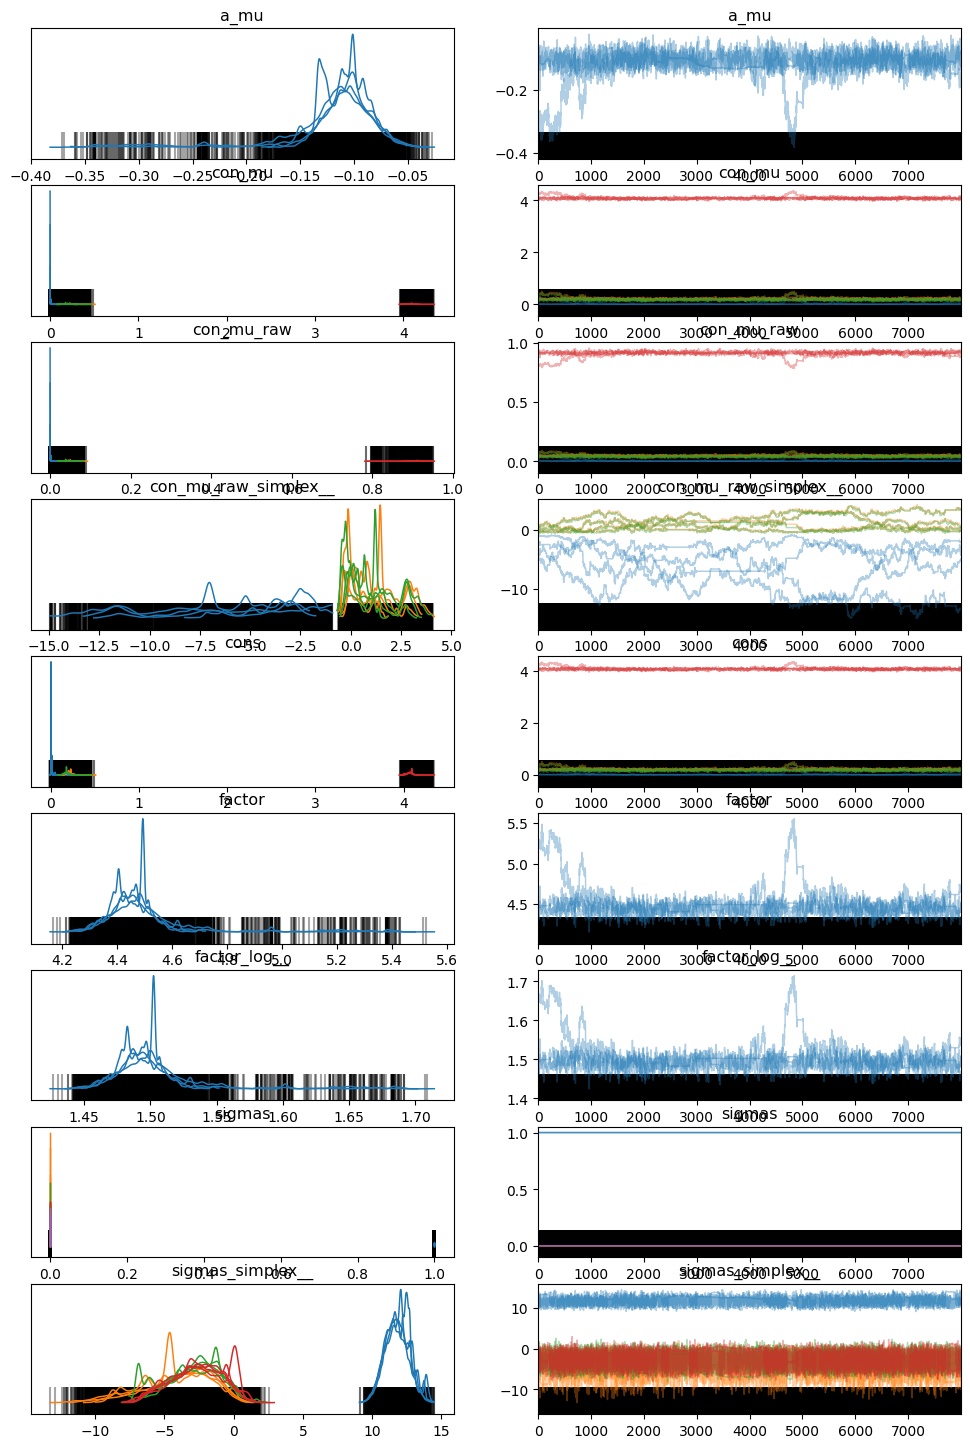

In [92]:
az.plot_trace(trace_nutpie,
              compact="true",
    chain_prop={"ls": "-"},)

# Model Selection via PPC
* see [Prior and Posterior Predictive Checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)
* maybe [BART / Bayesian additive regression trees](https://www.pymc.io/projects/bart/en/latest/examples/bart_introduction.html) can enhance the modeling

In [19]:
with model0:
    idata = pm.sample_prior_predictive(draws=50)

Sampling: [a_mu, a_sigma, con_sigmas, cons, value]


In [21]:

az.plot_ppc(idata.posterior, num_pp_samples=100);

AttributeError: 'InferenceData' object has no attribute 'posterior'

In [22]:
idata.prior

<xarray.Dataset> Size: 3kB
Dimensions:           (chain: 1, draw: 50, con_sigmas_dim_0: 2, cons_dim_0: 2)
Coordinates:
  * chain             (chain) int32 4B 0
  * draw              (draw) int32 200B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * con_sigmas_dim_0  (con_sigmas_dim_0) int32 8B 0 1
  * cons_dim_0        (cons_dim_0) int32 8B 0 1
Data variables:
    a_mu              (chain, draw) float64 400B -3.888 8.243 ... 1.139 10.28
    a_sigma           (chain, draw) float64 400B 0.3543 0.7871 ... 1.927 0.645
    con_sigmas        (chain, draw, con_sigmas_dim_0) float64 800B 0.8964 ......
    cons              (chain, draw, cons_dim_0) float64 800B -0.07385 ... 0.4735
Attributes:
    created_at:                 2024-09-20T05:13:44.670094+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2